In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler

In [2]:
with open('/home/docker_current/py_files/MLCLIP_exp/image_feat_array.npy', 'rb') as f:
    image_feat_array = np.load(f)

with open('/home/docker_current/py_files/MLCLIP_exp/text_feat_array.npy', 'rb') as f:
    text_feat_array = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(text_feat_array, image_feat_array, 
                                                        test_size=0.25, random_state=42)

In [3]:
X_train, y_train  = np.vstack((X_train, y_train)), np.vstack((y_train, X_train))
# X_test, y_test = np.vstack((X_test, y_test)), np.vstack((y_test, X_test))

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3146, 768), (3146, 768), (525, 768), (525, 768))

In [5]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t = torch.FloatTensor(X_test) 
y_val_t = torch.FloatTensor(y_test) 

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [25]:
class DumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 768)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DumNet_4l(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 256)
        self.dropout = nn.Dropout(p=0.4)
        self.fc4 = nn.Linear(256, 768)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DumNet_4l().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [27]:
max_epochs = 1000
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        if k == 'train':
            exp_lr_scheduler.step()
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. loss: {loss}")
        accuracy[k].append(loss)

    exp_lr_scheduler.step()

Epoch: 1
Loader: train. loss: 0.07898742705583572
Loader: valid. loss: 0.3337125778198242
Epoch: 2
Loader: train. loss: 0.07072427868843079
Loader: valid. loss: 0.1917511522769928
Epoch: 3
Loader: train. loss: 0.06485265493392944
Loader: valid. loss: 0.1397162526845932
Epoch: 4
Loader: train. loss: 0.05965244397521019
Loader: valid. loss: 0.13784296810626984
Epoch: 5
Loader: train. loss: 0.05702195316553116
Loader: valid. loss: 0.14060074090957642
Epoch: 6
Loader: train. loss: 0.05526918172836304
Loader: valid. loss: 0.15175387263298035
Epoch: 7
Loader: train. loss: 0.054128799587488174
Loader: valid. loss: 0.1290425807237625
Epoch: 8
Loader: train. loss: 0.049932096153497696
Loader: valid. loss: 0.12737540900707245
Epoch: 9
Loader: train. loss: 0.047871414572000504
Loader: valid. loss: 0.11283168196678162
Epoch: 10
Loader: train. loss: 0.04413721337914467
Loader: valid. loss: 0.11188001185655594
Epoch: 11
Loader: train. loss: 0.044489018619060516
Loader: valid. loss: 0.114821732044219

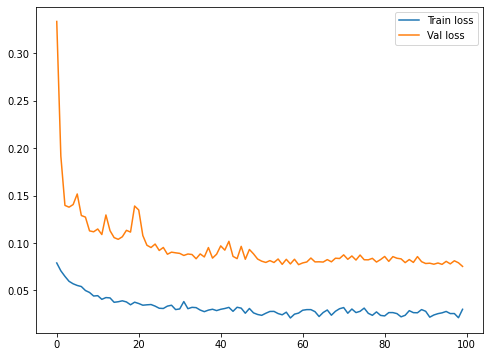

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy['train'][0:100], label='Train loss')
plt.plot(accuracy['valid'][0:100], label='Val loss')
plt.legend()

In [30]:
print(criterion(model(X_val_t.to(device)), y_val_t.to(device)))
print(criterion(model(y_val_t.to(device)), X_val_t.to(device)))

tensor(0.0958, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)


In [33]:
torch.save(model.state_dict(), 'symmetr_dataset_dummynet_4l.pth')

In [31]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

def get_similarity(image_emb, text_emb):
    sim =cos(torch.Tensor(image_emb), 
                        torch.Tensor(text_emb))
    return sim

In [32]:
ind = 0
emb_before_model = X_val_t[ind].unsqueeze(dim=0).cpu()
emb_after_model = model(emb_before_model.to(device)).cpu()
target = y_val_t[ind].unsqueeze(dim=0).cpu()

cos(emb_before_model, target), cos(emb_after_model, target), cos(emb_after_model, emb_before_model)

(tensor([0.2866]),
 tensor([0.8582], grad_fn=<DivBackward0>),
 tensor([0.2584], grad_fn=<DivBackward0>))